<a href="https://colab.research.google.com/github/solee328/LikeLion_EDA/blob/test/EDA_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import missingno as msno
%matplotlib inline

## 데이터 불러오기


In [1]:
cd drive/MyDrive/data/COVID-19

/content/drive/MyDrive/data/COVID-19


In [4]:
patient_info = pd.read_csv('PatientInfo.csv')
patient_route = pd.read_csv('PatientRoute.csv')

In [5]:
patient_info.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [15]:
patient_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3388 entries, 0 to 3387
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          3388 non-null   int64  
 1   global_num          2276 non-null   float64
 2   sex                 3311 non-null   object 
 3   birth_year          2927 non-null   float64
 4   age                 3304 non-null   object 
 5   country             3388 non-null   object 
 6   province            3388 non-null   object 
 7   city                3309 non-null   object 
 8   disease             18 non-null     object 
 9   infection_case      2620 non-null   object 
 10  infection_order     31 non-null     float64
 11  infected_by         822 non-null    float64
 12  contact_number      643 non-null    float64
 13  symptom_onset_date  481 non-null    object 
 14  confirmed_date      3385 non-null   object 
 15  released_date       1327 non-null   object 
 16  deceas

In [6]:
patient_route.head()

,patient_id,global_num,date,province,city,type,latitude,longitude
0,1000000001,2.0,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.615246,126.715632
1,1000000001,2.0,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659
2,1000000002,5.0,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048
3,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822
4,1000000002,5.0,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534


## 필요한 데이터 추출
patientInfo의 경우 policy와 연결시켜야 하므로 confirmed_date(확진판정날짜)를 중심으로 나눌 수 있도록 하며 결측치를 확인합니다.  

patientRoute의 경우 type에서 음식점과 관련된 데이터들만 따로 추출해야 합니다.

### patientInfo

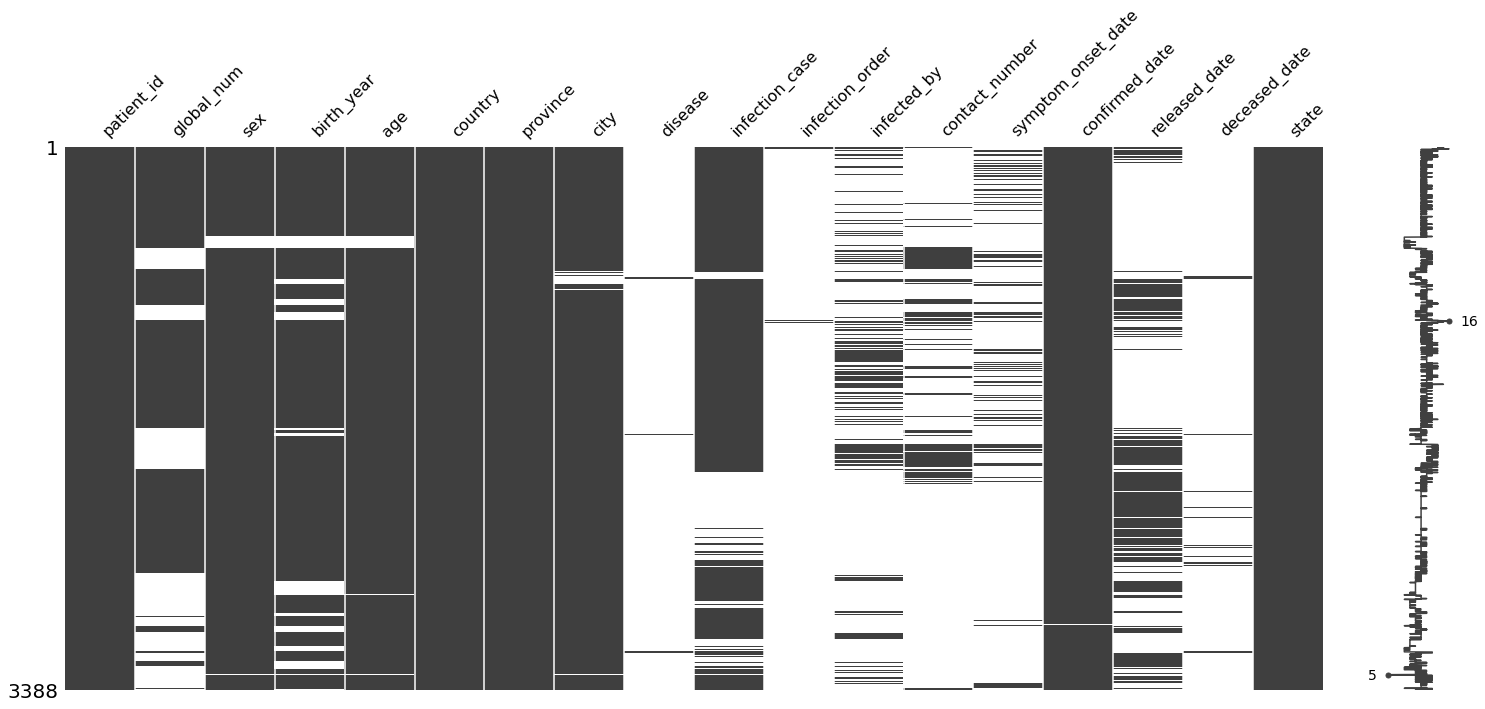

In [12]:
msno.matrix(patient_info)

In [14]:
patient_info['confirmed_date'].isnull().sum()

3

confirmed_date가 없는 데이터는 3388 row 중 3 row로 유추할 수 있는 추가적인 데이터가 없다고 판단되어 해당 row들을 삭제합니다.

In [30]:
patient_need_date = patient_info[patient_info['confirmed_date'].isnull()]
patient_need_date

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
2980,6011000051,NaN,female,1980.0,40s,Korea,Gyeongsangbuk-do,Andong-si,NaN,etc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,isolated
2981,6011000052,NaN,female,2011.0,0s,Korea,Gyeongsangbuk-do,Andong-si,NaN,etc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,isolated
2982,6011000053,NaN,female,2001.0,10s,Korea,Gyeongsangbuk-do,Andong-si,NaN,etc,NaN,NaN,NaN,2020-04-15,NaN,NaN,NaN,isolated


In [31]:
patient_info.dropna(subset=['confirmed_date'], inplace=True)

In [32]:
patient_info['confirmed_date'].isnull().sum()

0

patient_info의 confirmed_date에 NaN값이 있던 행들을 삭제합니다.

In [34]:
type(patient_info['confirmed_date'][0])

str

In [35]:
patient_info['confirmed_date'] = pd.to_datetime(patient_info['confirmed_date'], format='%Y-%m-%d')

In [36]:
type(patient_info['confirmed_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [54]:
def extract_by_date(df, date):
  ds = list(map(int, date[0].split('-')))
  de = list(map(int, date[1].split('-')))
  start = pd.Timestamp(ds[0], ds[1], ds[2]).strftime('%Y-%m-%d')
  end = pd.Timestamp(de[0], de[1], de[2]).strftime('%Y-%m-%d')

  mask = (start <= df['confirmed_date']) & (df['confirmed_date']<=end)
  return df.loc[mask]
  

In [72]:
date_1 = extract_by_date(patient_info, ["2020-02-15", "2020-03-10"])

In [73]:
date_1_count = date_1.groupby(['confirmed_date']).size().reset_index(name='counts')

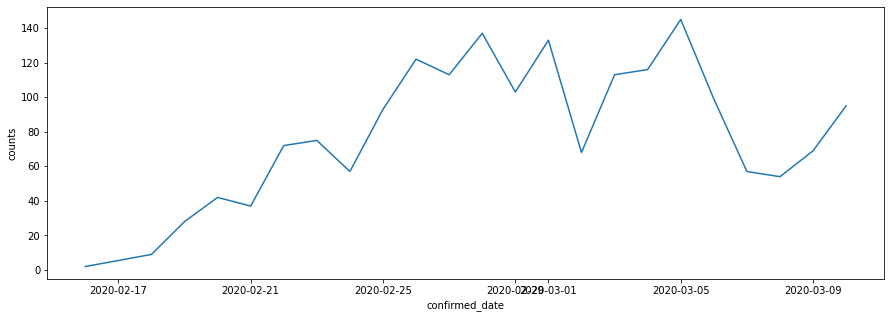

In [79]:
rcParams['figure.figsize'] = 15,5
sns.lineplot(x='confirmed_date', y='counts', data=date_1_count)

confirmed_date의 type을 str에서 timestamp로 변경해 특정 날짜의 데이터를 추출할 수 있는 ```extract_by_date``` 함수를 만들었습니다.  

예시로 2020-02-15부터 2020-03-10까지의 확진검진을 받은 환자들을 카운트한 lineplot을 그렸습니다.

### patientRoute